# SVM in Python

In [2]:

%matplotlib inline
%config InlineBackend.figure_format='retina'

import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import pdist, squareform

import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils
import sklearn.linear_model as linear_model
import sklearn.svm as svm
import sklearn.cross_validation as cross_validation
import sklearn.cluster as cluster
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from patsy import dmatrices

import seaborn as sns


import slideUtilities as sl
import laUtilities as ut
from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
print('')

/Users/markcrovella/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

## Support Vector Machines (SVM)

Working with the wine dataset available here:

https://archive.ics.uci.edu/ml/datasets/Wine

In [4]:
wine = pd.read_table("data/wine.data", sep=',')

attributes = ['region',
'Alcohol',
            'Malic acid',
            'Ash',
            'Alcalinity of ash',
            'Magnesium',
            'Total phenols',
            'Flavanoids',
            'Nonflavanoid phenols',
            'Proanthocyanins',
            'Color intensity',
            'Hue',
            'OD280/OD315 of diluted wines',
            'Proline']



wine.columns = attributes
# take 2 attributes and use a two dimensional training dataset
X = wine[['Alcohol', 'Malic acid',]].values
#            'Ash',
#            'Alcalinity of ash',
#            'Magnesium',
#            'Total phenols',
#            'Flavanoids', 'Nonflavanoid phenols','Proanthocyanins','Color intensity',  'Hue', 'OD280/OD315 of diluted wines', 'Proline']].values
grape = wine.pop('region')
y = grape.values
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 13 columns):
Alcohol                         177 non-null float64
Malic acid                      177 non-null float64
Ash                             177 non-null float64
Alcalinity of ash               177 non-null float64
Magnesium                       177 non-null int64
Total phenols                   177 non-null float64
Flavanoids                      177 non-null float64
Nonflavanoid phenols            177 non-null float64
Proanthocyanins                 177 non-null float64
Color intensity                 177 non-null float64
Hue                             177 non-null float64
OD280/OD315 of diluted wines    177 non-null float64
Proline                         177 non-null int64
dtypes: float64(11), int64(2)
memory usage: 18.1 KB


In [5]:
wine.head()
print(X.shape)

X, y = utils.shuffle(X, y, random_state=1)
print(X.shape)
print(y.shape)
print(y)

train_set_size = 100
X_train = X[:train_set_size]  # selects first 100 rows (examples) for train set
y_train = y[:train_set_size]
X_test = X[train_set_size:]   # selects from row 100 until the last one for test set
y_test = y[train_set_size:]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(177, 2)
(177, 2)
(177,)
[2 2 1 2 1 3 2 1 2 2 1 1 2 1 2 2 3 1 2 1 1 2 3 2 1 2 1 1 1 2 3 3 3 1 2 2 2
 3 2 1 1 2 2 1 1 1 2 1 1 2 2 2 3 1 2 2 1 2 3 2 2 1 3 3 2 1 2 1 2 1 3 3 3 3
 2 1 3 1 2 3 1 2 1 3 2 2 1 2 2 3 1 2 2 2 3 2 2 2 3 1 1 1 3 1 2 3 3 1 2 1 2
 2 1 3 2 3 3 3 2 2 2 3 3 2 1 2 1 3 2 2 1 1 2 1 1 1 3 1 3 3 1 2 2 3 1 2 2 1
 1 1 2 2 1 3 3 2 2 2 1 3 3 3 3 3 2 1 1 3 2 3 3 2 3 3 2 3 1]
(100, 2) (100,)
(77, 2) (77,)


##### Using the SVM library of scikit-learn:  http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [6]:
svc = svm.SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred_test = svc.predict(X_test)
print("Accuracy of SVM test set:", svc.score(X_test, y_test))

Accuracy of SVM test set: 0.714285714286


Evaluating the fit of the classifier graphically

In [7]:
from matplotlib.colors import ListedColormap
# Create color maps for 3-class classification problem, as with iris
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_estimator(estimator, X, y):
    
    try:
        X, y = X.values, y.values
    except AttributeError:
        pass
    
    estimator.fit(X, y)
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.axis('tight')
    plt.axis('off')
    plt.tight_layout()

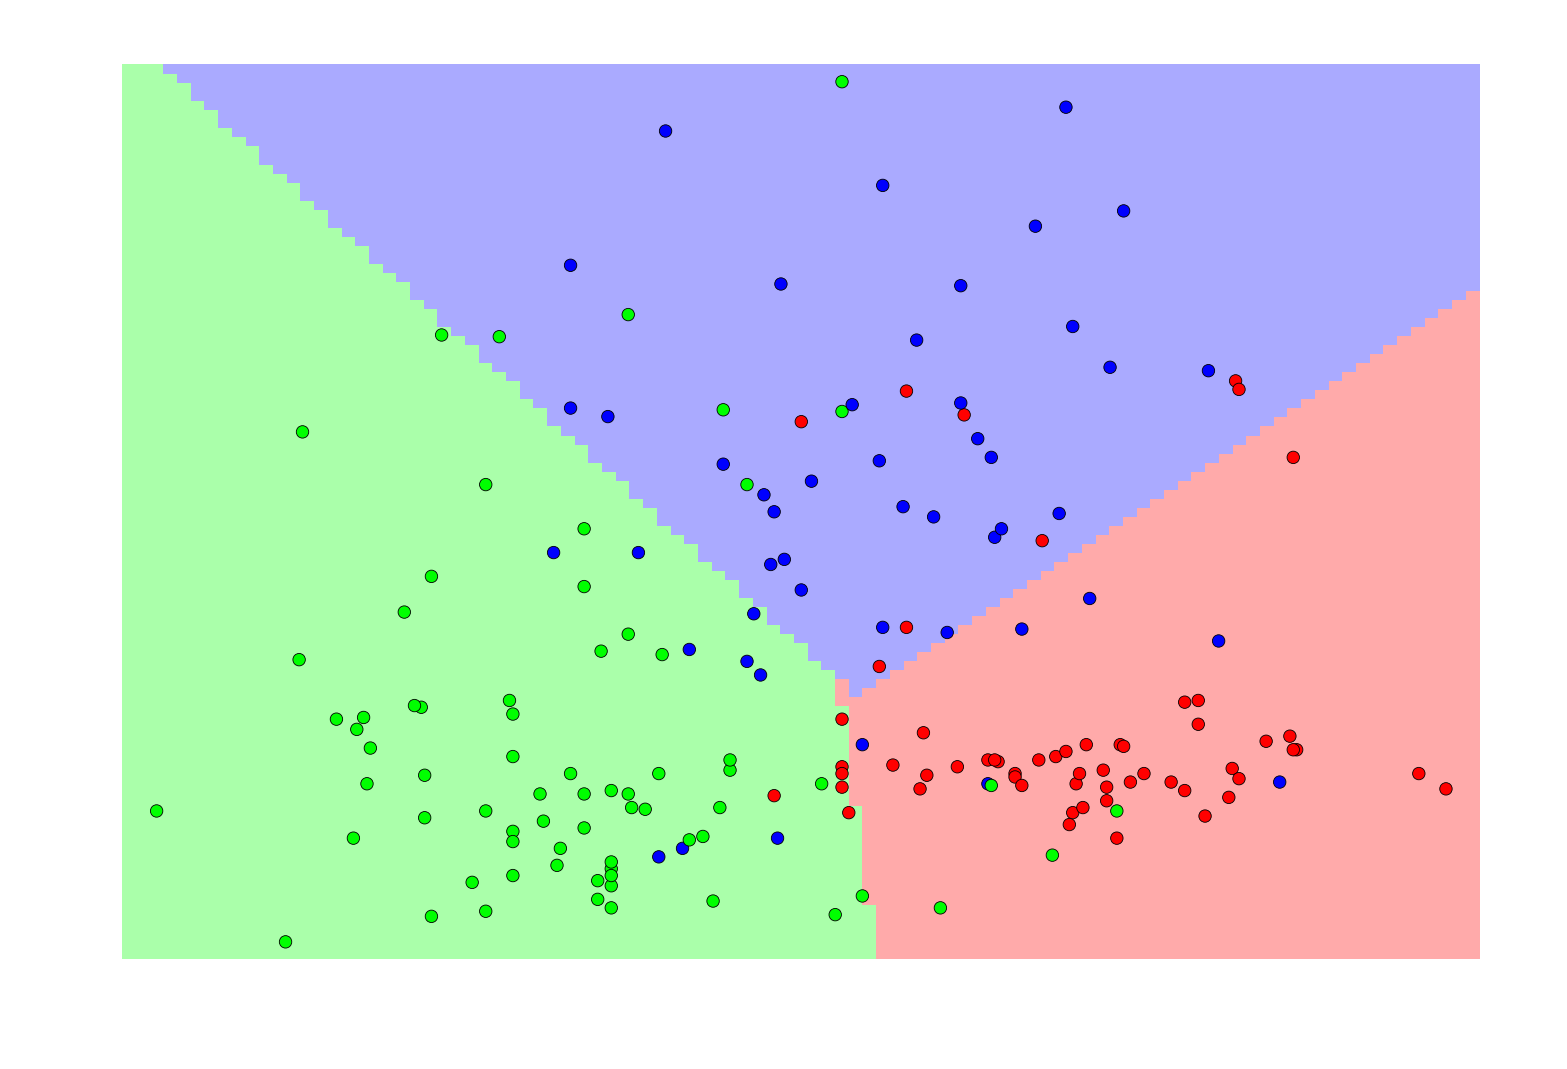

In [8]:
plot_estimator(svc, X, y)

The SVM gets its name from the samples in the dataset from each class that lie closest to the other class. These training samples are called "support vectors" because changing their position in p-dimensional space would change the location of the decision boundary.

In `scikit-learn`, the indices of the support vectors for each class can be found in the `support_vectors_` attribute of the SVC object. 

Here is a 2 class problem using only classes 1 and 2 in the wine dataset.

The support vectors are circled.

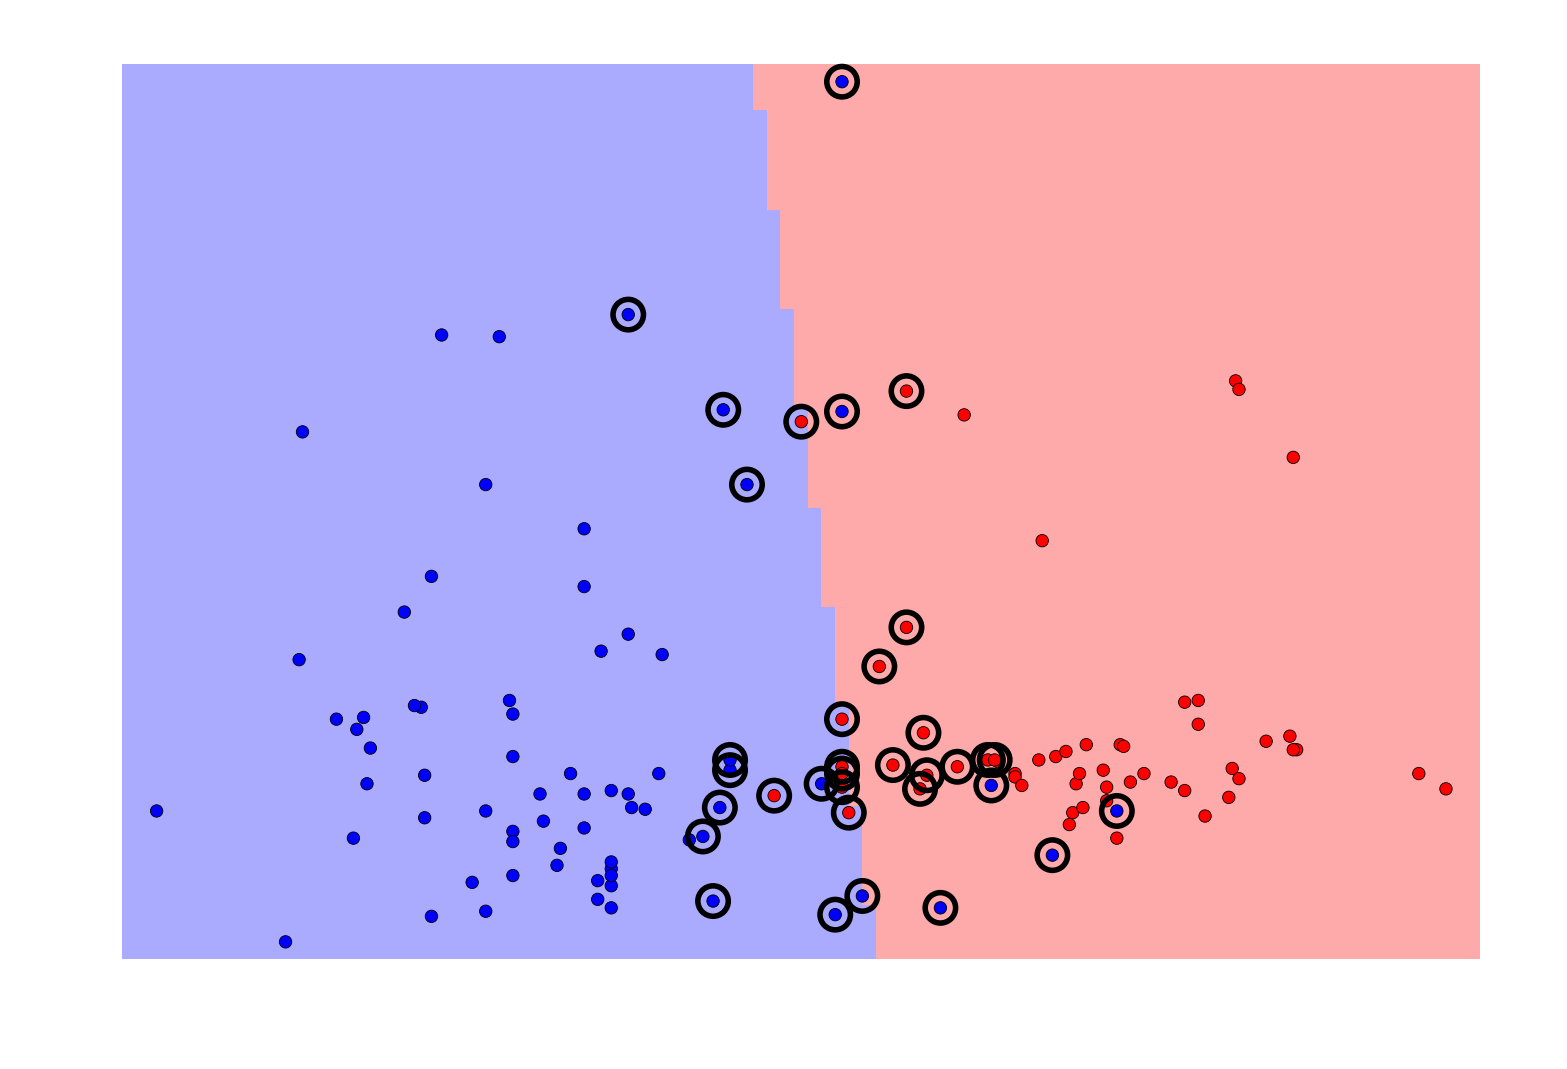

In [9]:
# Extract classes 1 and 2
X, y = X[np.in1d(y, [1, 2])], y[np.in1d(y, [1, 2])]

plot_estimator(svc, X, y)
plt.scatter(svc.support_vectors_[:, 0], 
           svc.support_vectors_[:, 1], 
           s=120, 
           facecolors='none', 
           linewidths=2,
           zorder=10)

## Regularization

These two classes do not appear to be linearly separable.

For non-linearly separable classes we turn to __regularization.__

Regularization is tuned via the C parameter. 

In practice, a large C value means that the number of support vectors is small (less regularization), while a small C implies many support vectors (more regularization). 

`scikit-learn` sets a default value of C=1.

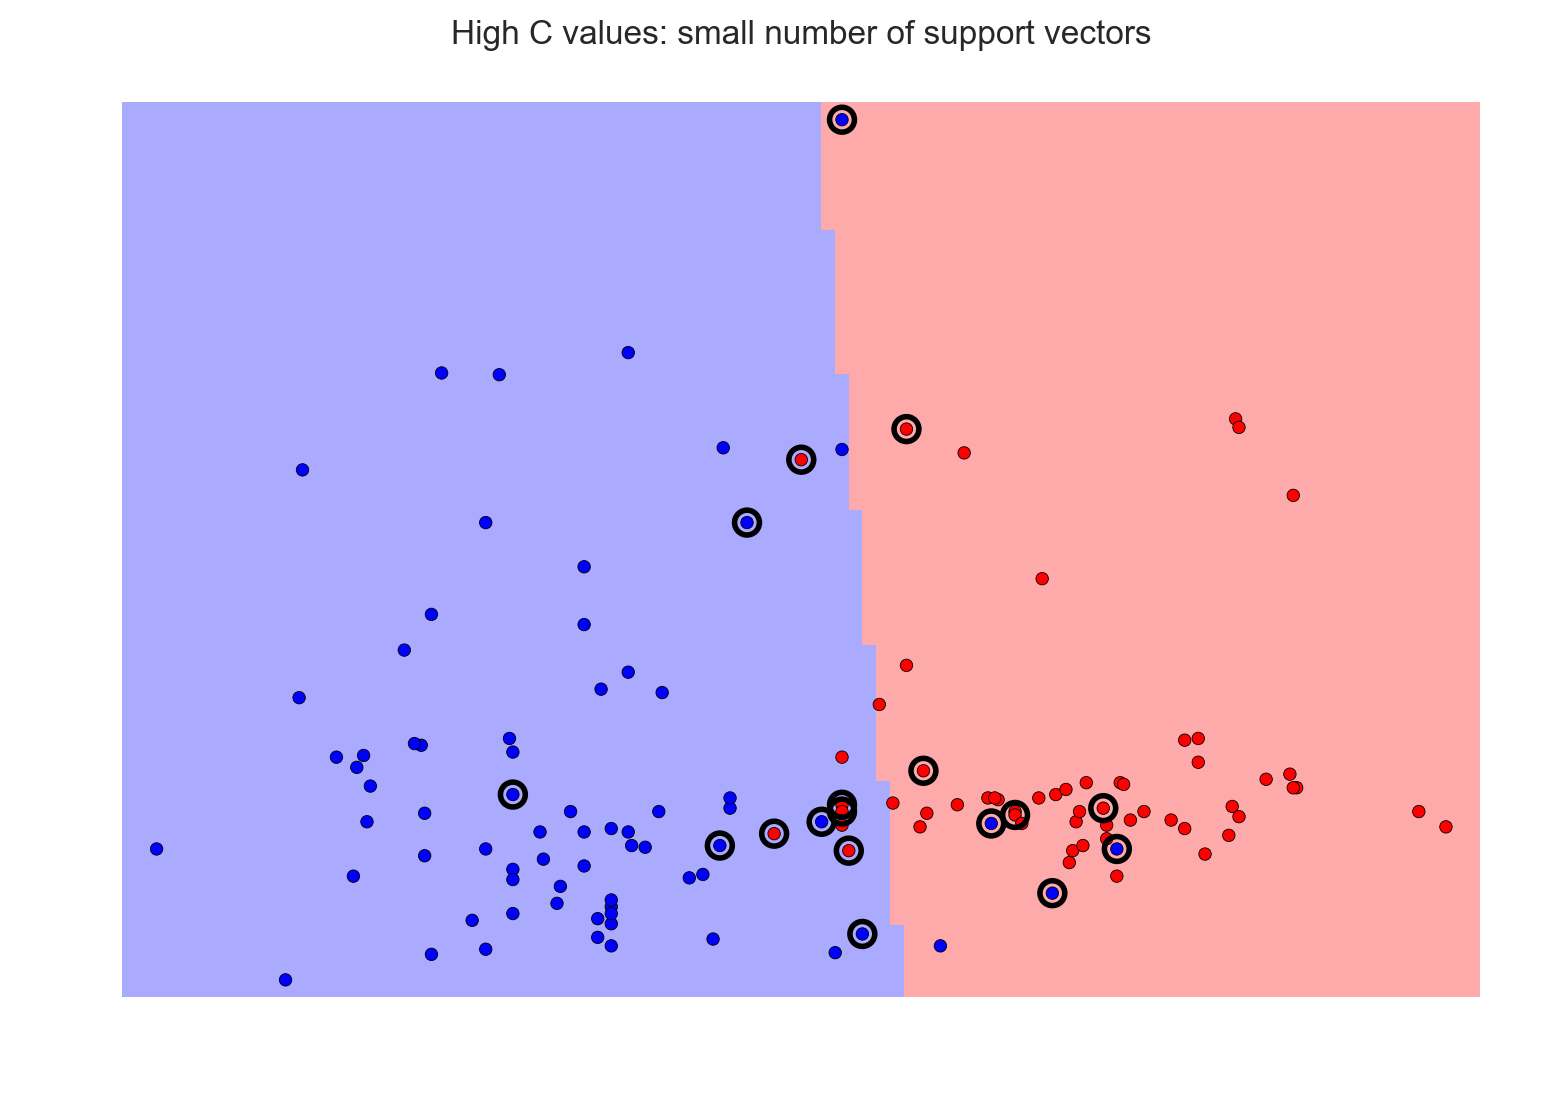

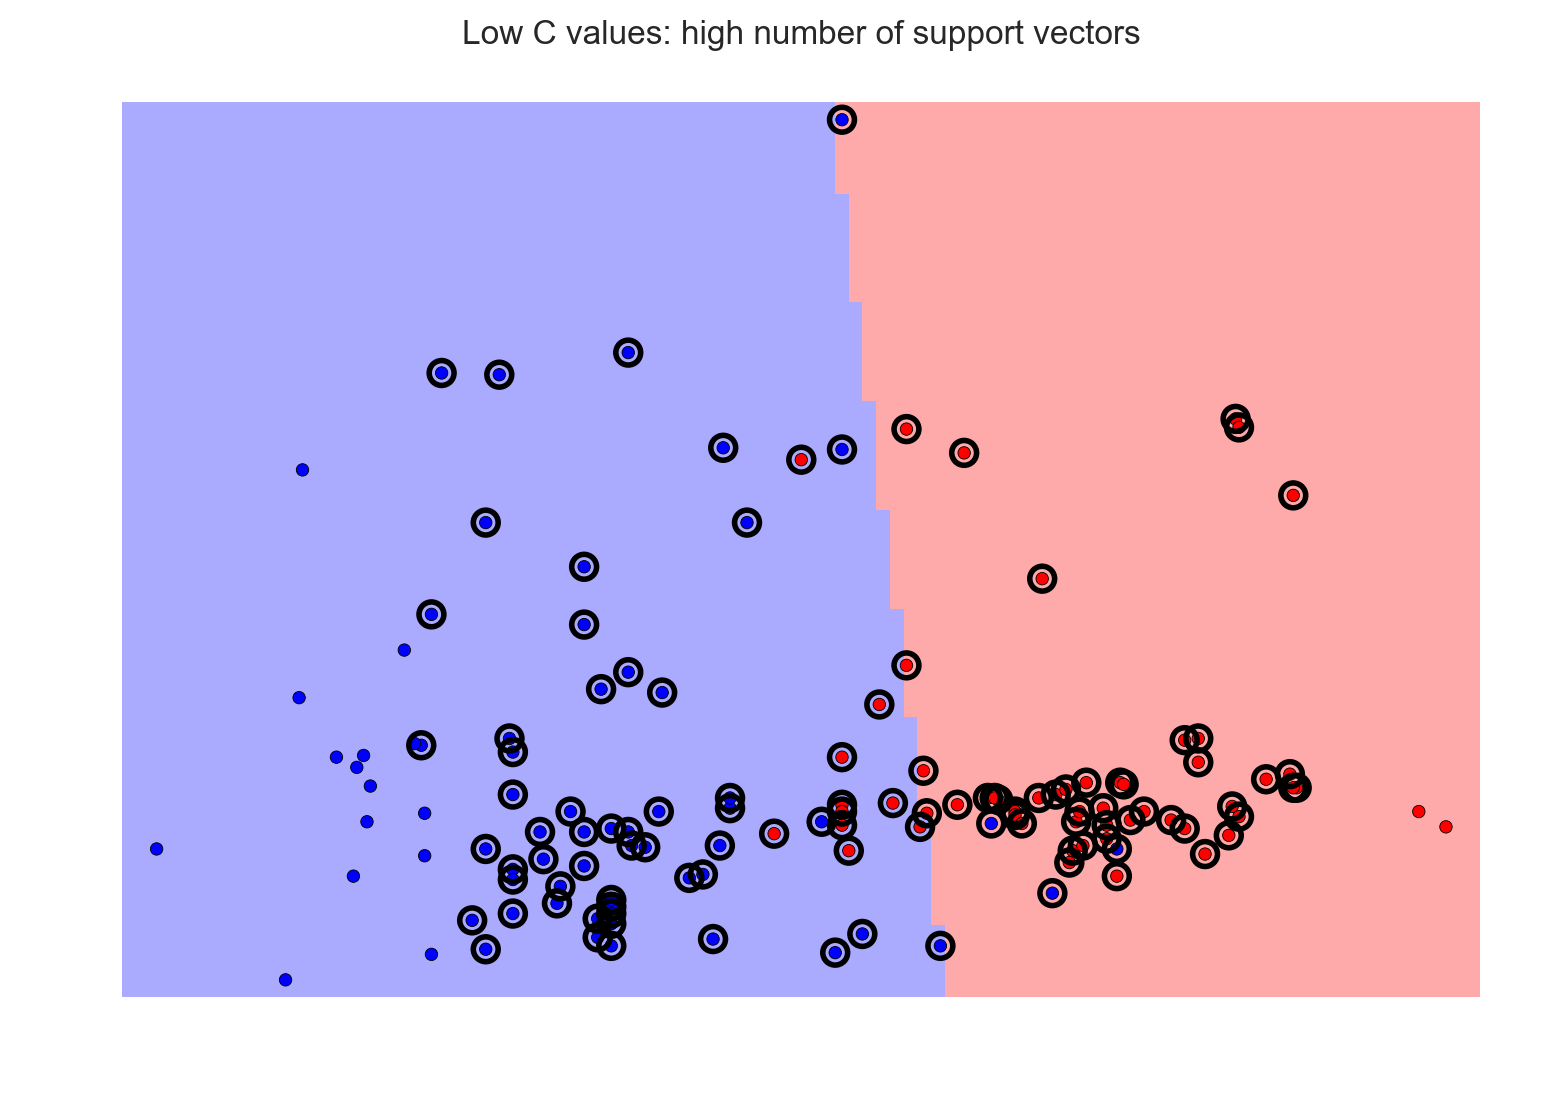

In [10]:
svc = svm.SVC(kernel='linear', C=1e6)
plot_estimator(svc, X, y)
plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, 
            facecolors='none', linewidths=2, zorder=10)
plt.title('High C values: small number of support vectors')

svc = svm.SVC(kernel='linear', C=1e-2)
plot_estimator(svc, X, y)
plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, 
            facecolors='none', linewidths=2, zorder=10)
plt.title('Low C values: high number of support vectors')

## Kernels

We can also choose from a suite of available kernels:

* linear, 
* poly, 
* rbf, 
* sigmoid, or 
* precomputed.

Or, a custom kernel can be passed as a function. 

Note that the radial basis function (rbf) kernel is just a Gaussian kernel, but with parameter $\gamma = \frac{1}{\sigma^2}$.

__Linear Kernel__

Accuracy of SVM test set: 0.922077922078


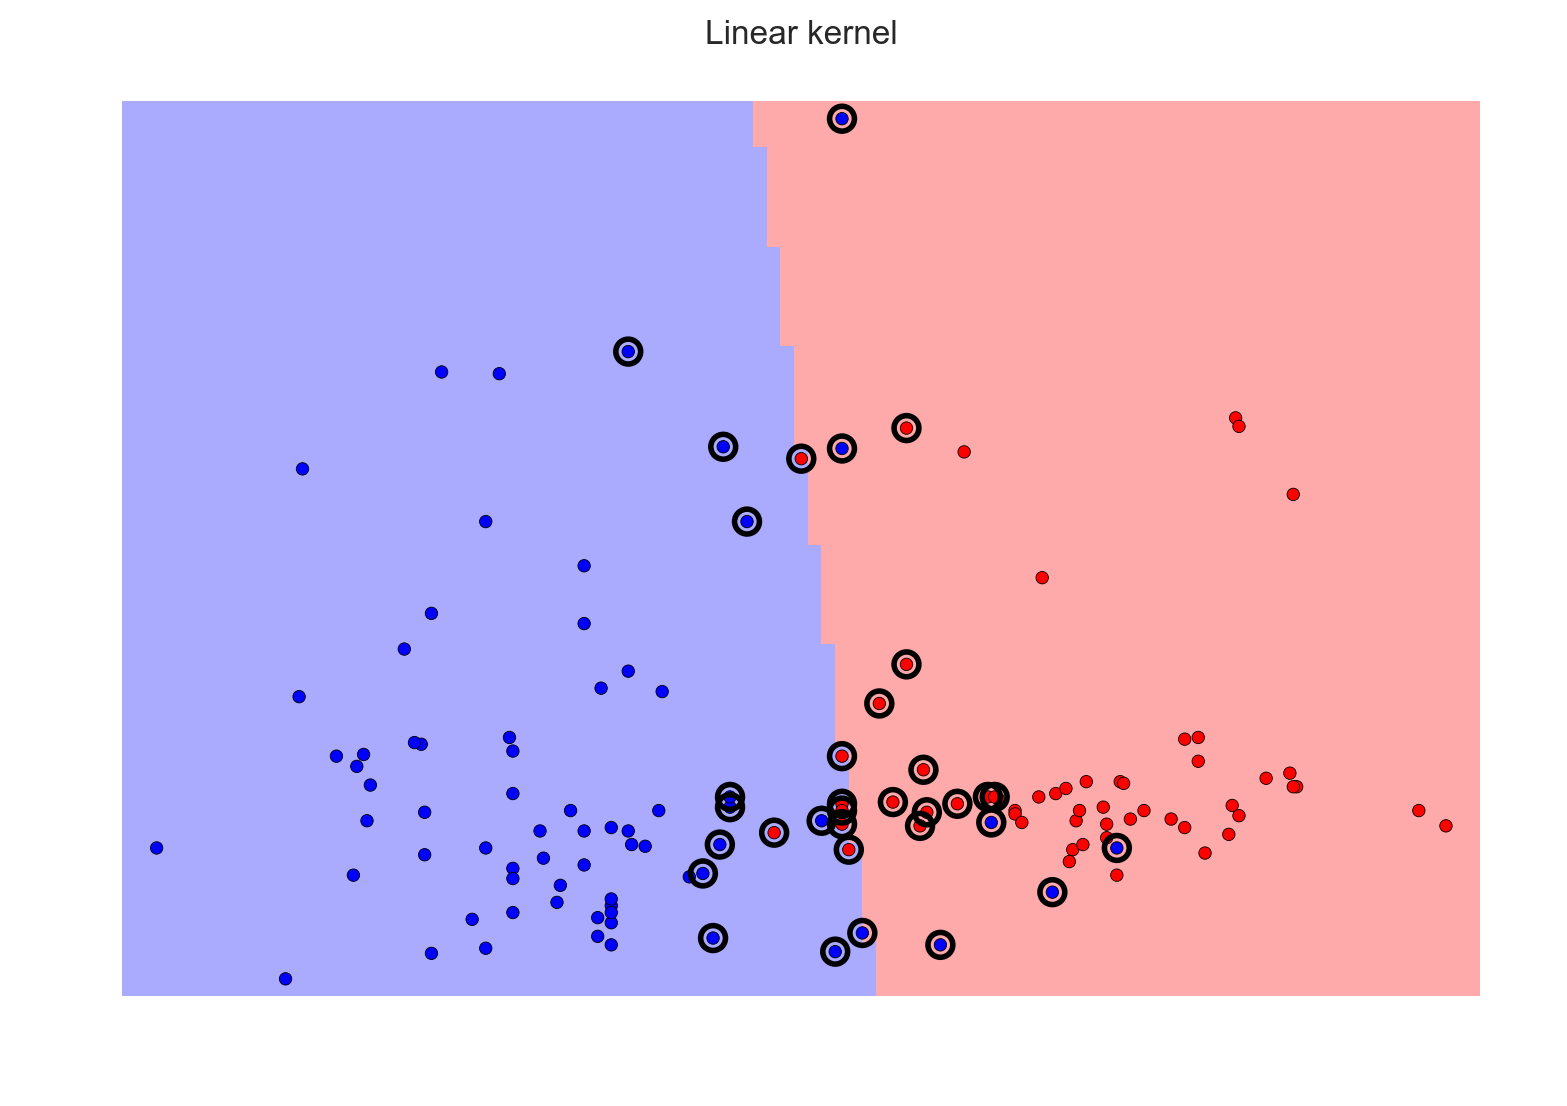

In [11]:
svc_lin = svm.SVC(kernel='linear')
plot_estimator(svc_lin, X, y)
plt.scatter(svc_lin.support_vectors_[:, 0], svc_lin.support_vectors_[:, 1], 
            s=80, facecolors='none', linewidths=2, zorder=10)
plt.title('Linear kernel')
y_pred_test = svc_lin.predict(X_test)
print("Accuracy of SVM test set:", svc.score(X_test, y_pred_test))

__Polynomial Kernel__

Accuracy of SVM test set: 0.831168831169


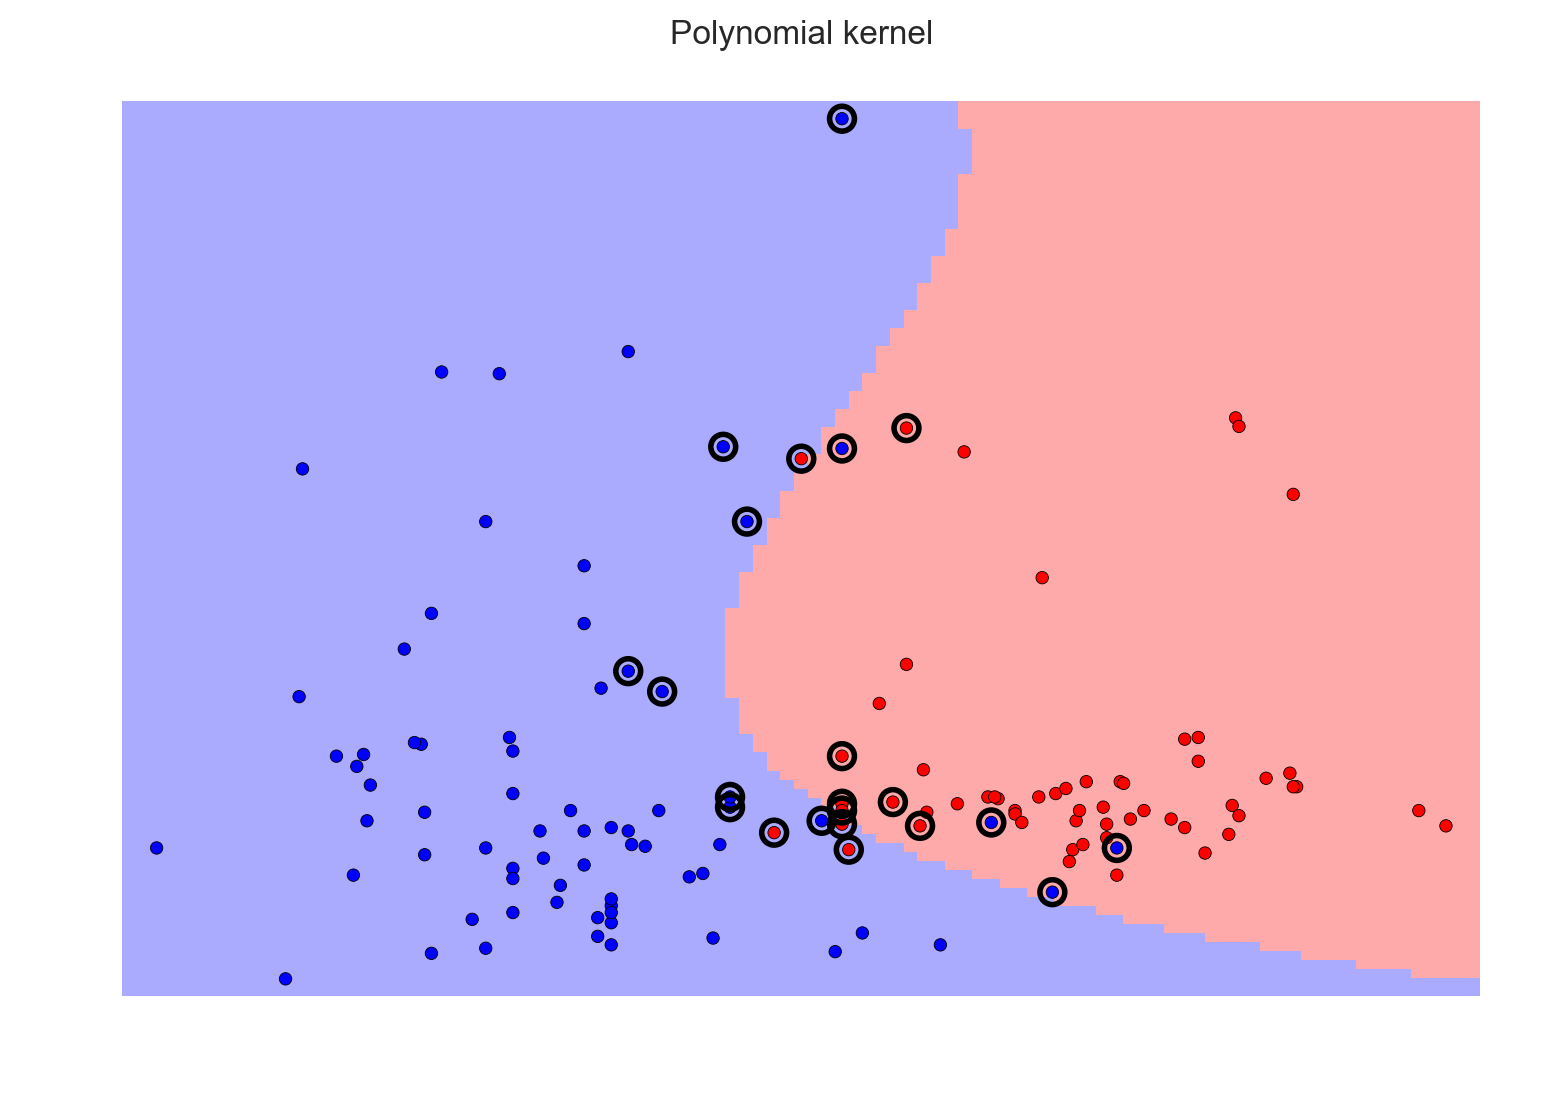

In [12]:
svc_poly = svm.SVC(kernel='poly', degree=3)
plot_estimator(svc_poly, X, y)
plt.scatter(svc_poly.support_vectors_[:, 0], svc_poly.support_vectors_[:, 1], 
           s=80, facecolors='none', linewidths=2, zorder=10)
plt.title('Polynomial kernel')
y_pred_test = svc_poly.predict(X_test)
print("Accuracy of SVM test set:", svc.score(X_test, y_pred_test))

__RBF kernel__

Accuracy of SVM test set: 0.987012987013


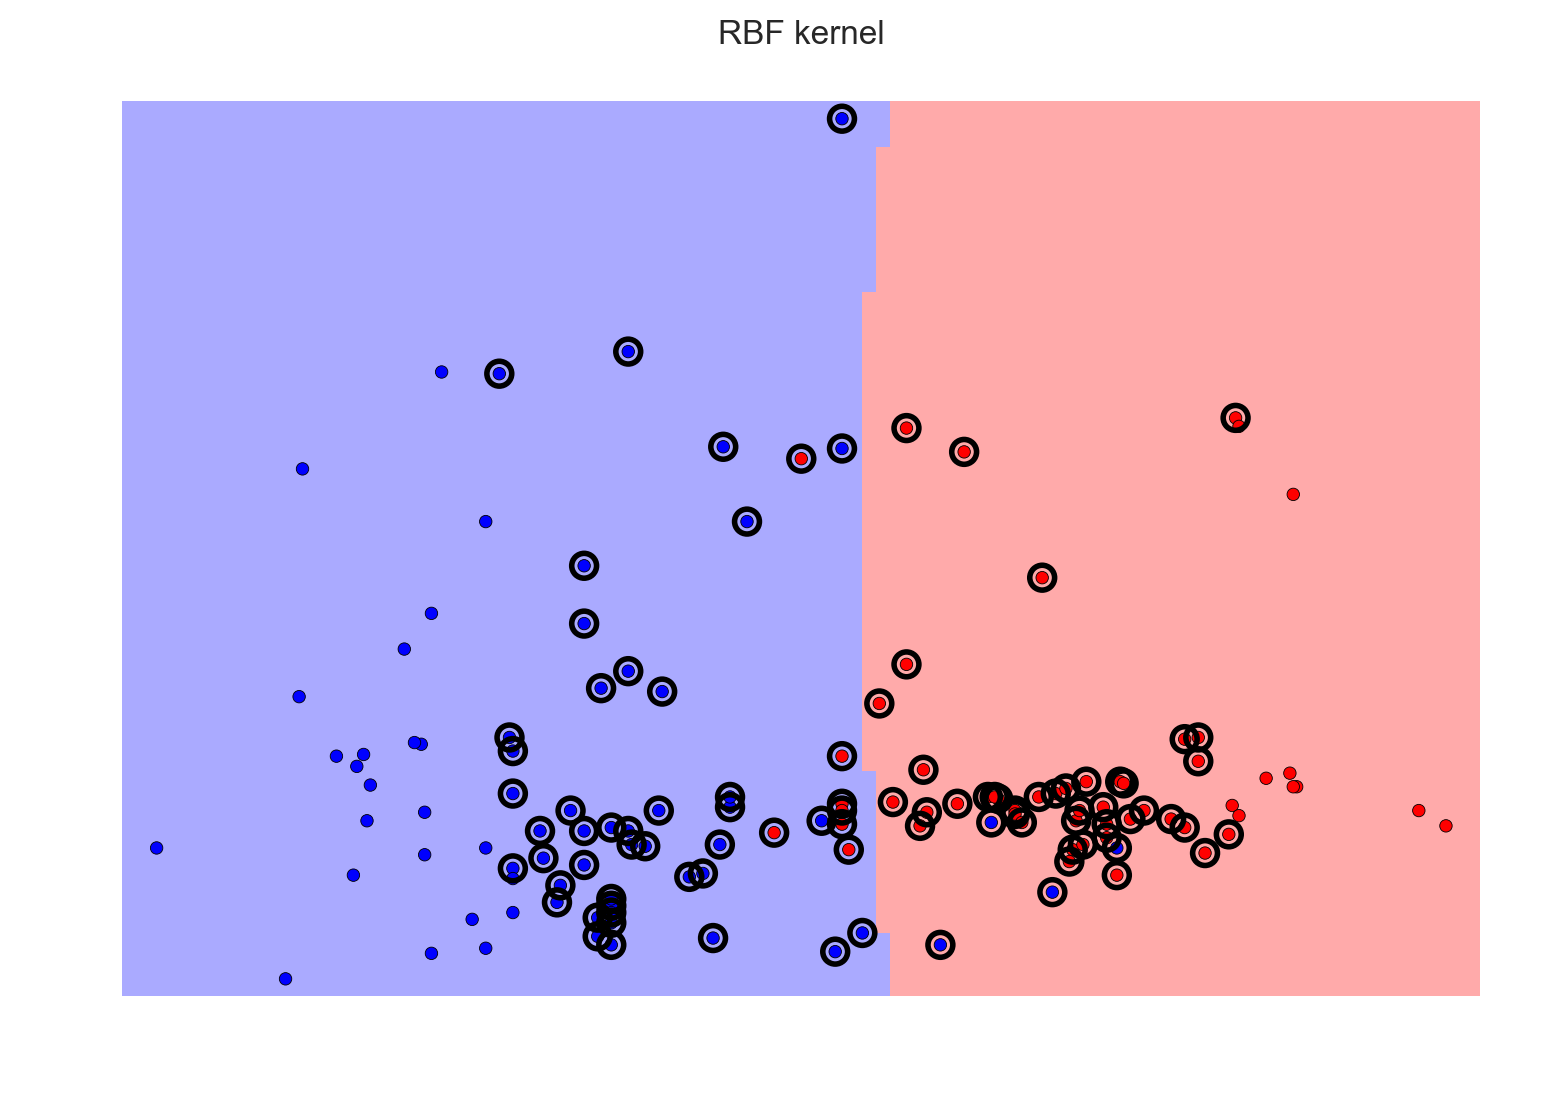

In [13]:
svc_rbf = svm.SVC(kernel='rbf', gamma=1e-2)
plot_estimator(svc_rbf, X, y)
plt.scatter(svc_rbf.support_vectors_[:, 0], svc_rbf.support_vectors_[:, 1], 
           s=80, facecolors='none', linewidths=2, zorder=10)
plt.title('RBF kernel')
y_pred_test = svc_rbf.predict(X_test)
print("Accuracy of SVM test set:", svc.score(X_test, y_pred_test))

## Cross-Validation

So far we've been evaluating our classifiers by 'holding out' test data.  

There is a problem with this, however: if we use the test data over and over, while varying model parameters, there is a new danger of overfitting.

The best way around this is to not use a fixed set of test data, but to sample the test data multiple times and look at the average behavior of the classifier.

In [14]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        wine.values, grape.values, test_size=0.4, random_state=0)

In [15]:
f = svm.SVC(kernel='linear', C=1)
f.fit(X_train, y_train)
f.score(X_test, y_test)

0.95774647887323938

So far, this is fine -- but what if we want to vary C?  Now, we are in danger of overfitting if we use the same test data to find the 'best' value of C.

In [16]:
#mean accuracy
scores = cross_validation.cross_val_score(f, wine.values, grape.values, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.86486486  0.97222222  0.94444444  1.          1.        ]
Accuracy: 0.96 (+/- 0.10)


## Analyzing the iris dataset

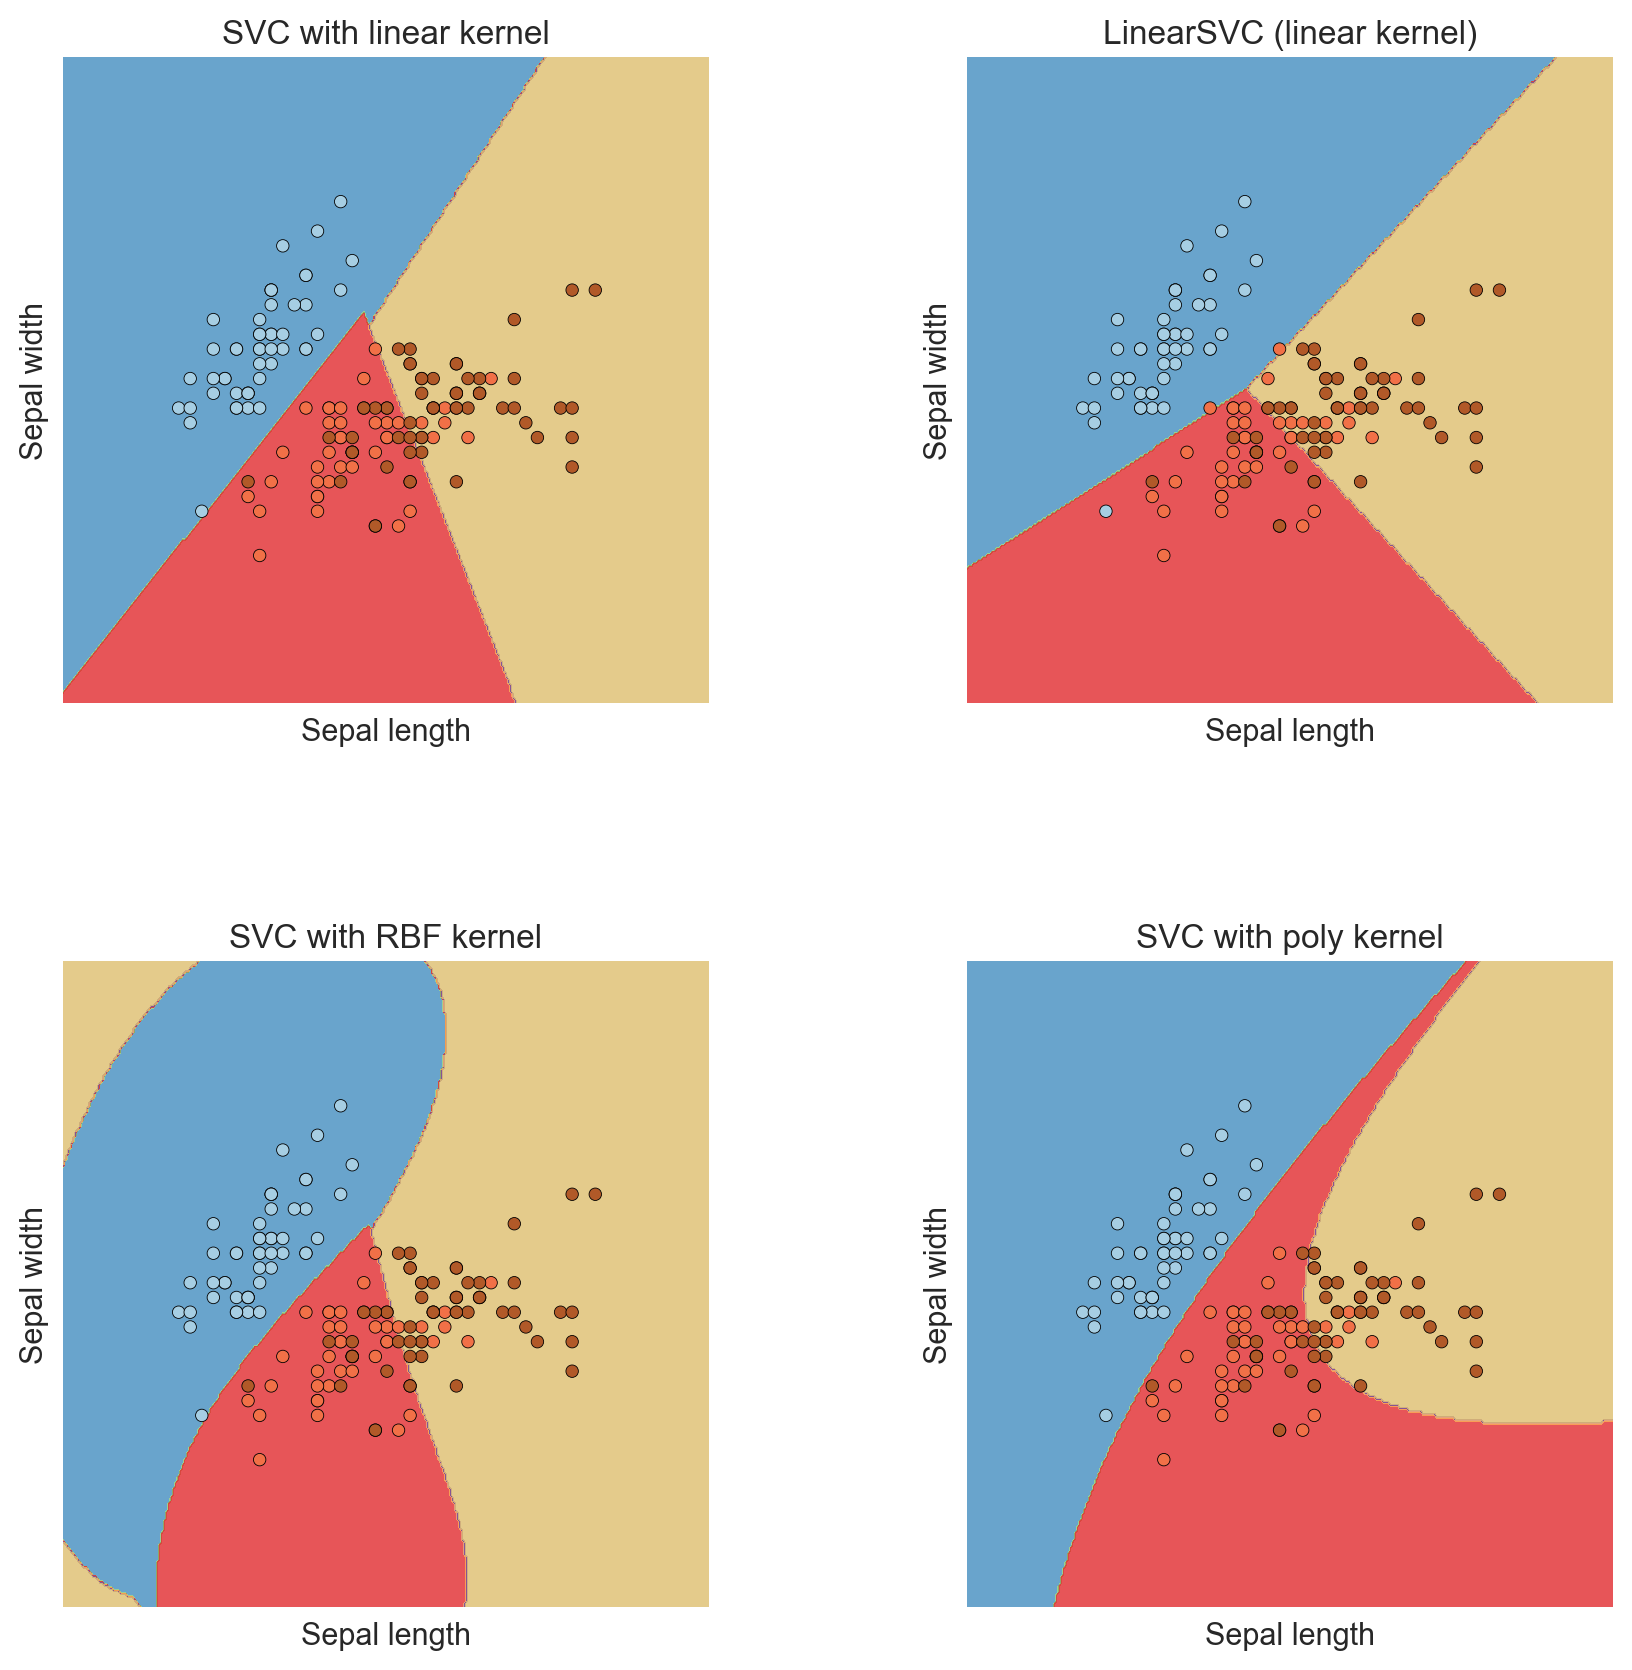

In [17]:
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel', 'SVC with poly kernel']

fig = plt.figure(figsize=(10,10))

for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()